In [1]:
import numpy as np
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
# sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
from pathlib import Path
resourcesdir=str(Path(utils.__file__).parents[1]) + '/resources'
import importlib
import matplotlib.pyplot as plt

In [2]:
# for l,label in enumerate(['hipp','dentate']):
#     for d,den in enumerate(['2mm','1mm','0p5mm','unfoldiso']):
#         cmd = f'wb_command -surface-vertex-areas {resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-{label}_midthickness.surf.gii {resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-{label}_surfarea.shape.gii'
#         !{cmd}

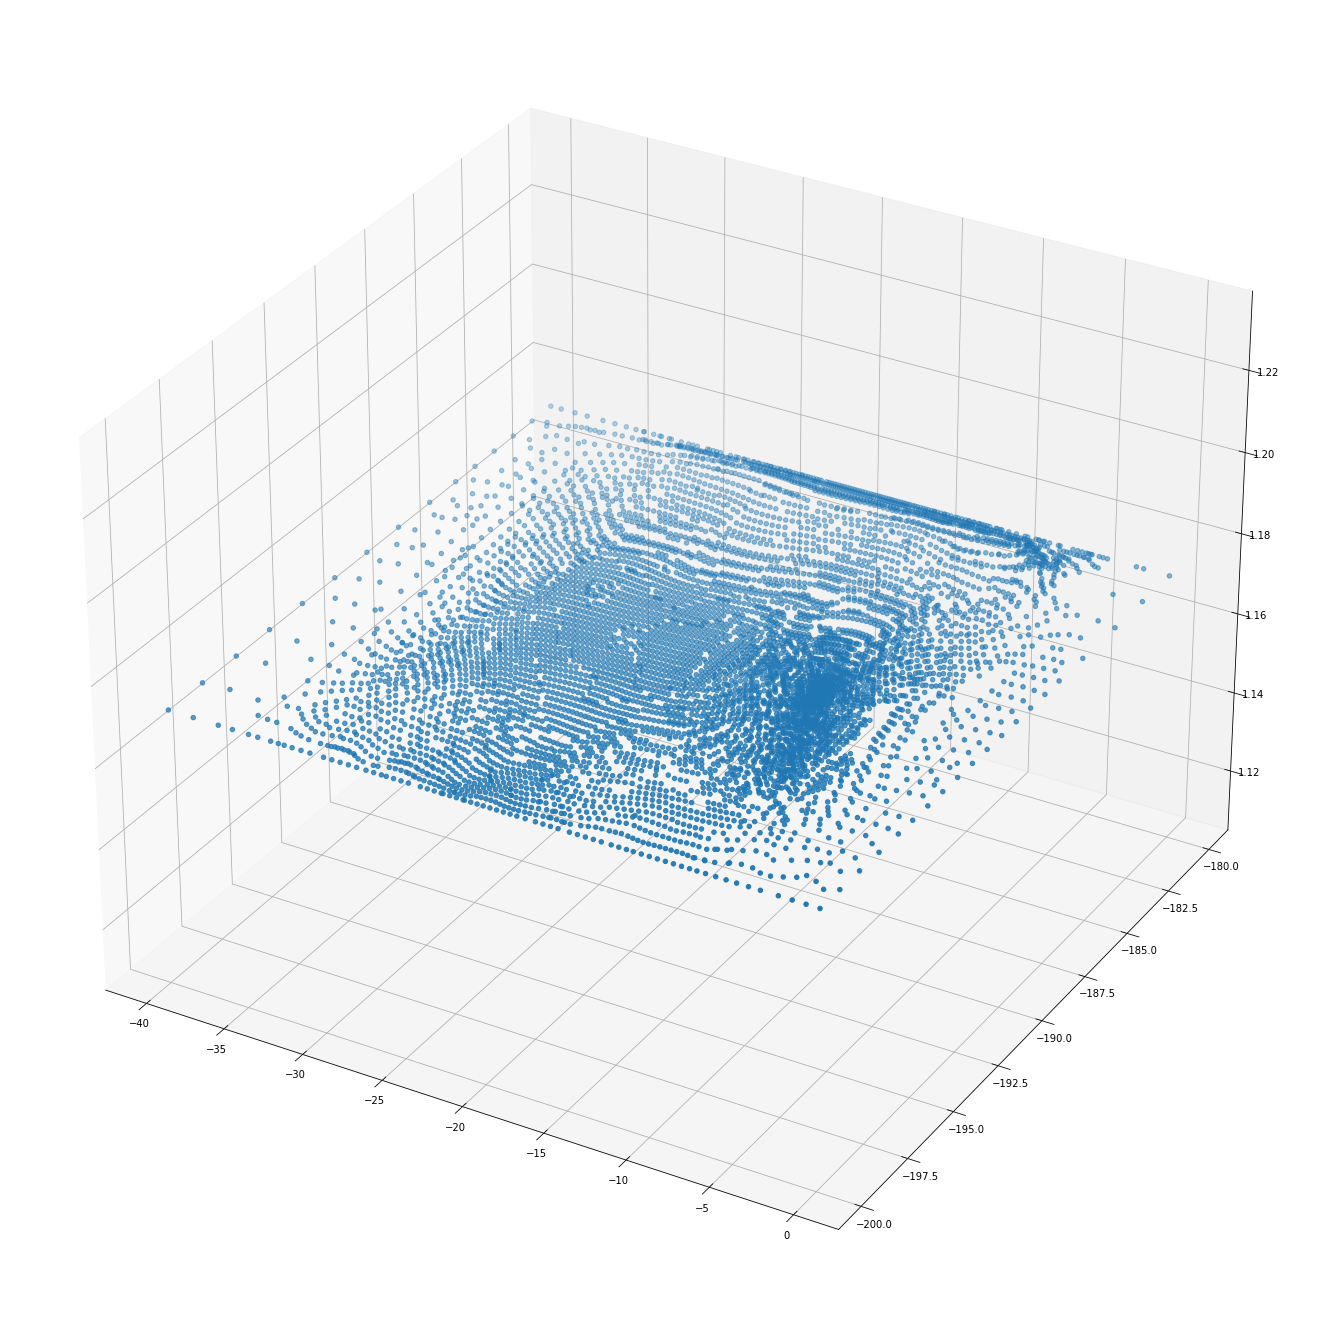

In [3]:
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
sub = 'HC002'
ses='ses-01'
uses = '_'+ses 
label='hipp'
den='0p5mm'
hemi='L'
space='unfold'
gii = nib.load(f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}{uses}_hemi-{hemi}_space-{space}_den-{den}_label-{label}_midthickness.surf.gii')
vertices = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
faces = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0],vertices[:,1],vertices[:,2])

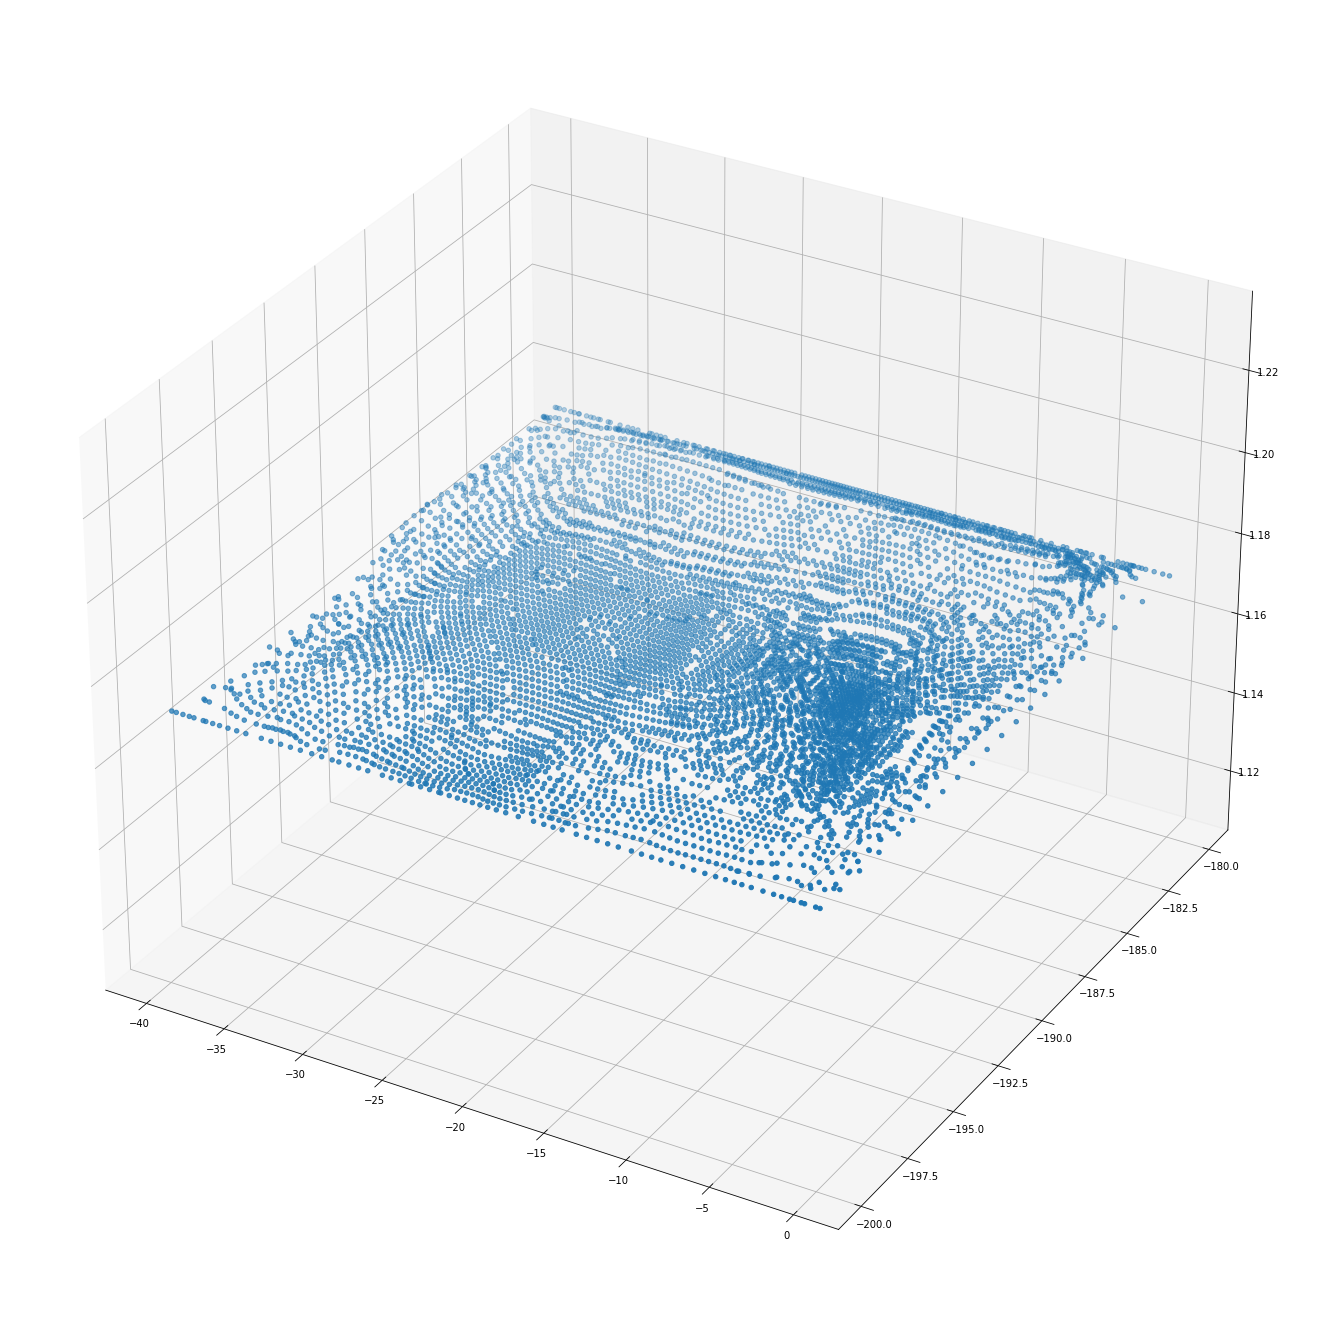

In [4]:
import importlib
importlib.reload(utils)

v2 = utils.area_rescale(vertices,den,label,APaxis=0)

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(projection='3d')
ax.scatter(v2[:,0],v2[:,1],v2[:,2])